# Imports

In [ ]:
#!pip install wordcloud
#!pip install dython

In [1]:
# For data
import os
import numpy as np
import pandas as pd

# For plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
from wordcloud import WordCloud

# For statistics and auxiliary functions
from collections import Counter
import itertools

# For geospatial analysis
from urllib.request import urlopen
import json
import geopandas as gpd
import plotly.express as px

# Set the style of the visualization
pd.set_option('future.no_silent_downcasting', True)   # use int instead of float in DataFrame
pd.set_option("display.max_columns", None)            # display all columns

# others
from IPython.display import display_html
from itertools import chain,cycle
from sklearn import preprocessing

# Disable warnings
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=SettingWithCopyWarning)

# For better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set_theme(style="white")

In [2]:
def display_side_by_side(*args, super_title, titles=cycle([''])):
    """
    :param args: Variable number of DataFrame objects to be displayed side by side.
    :param super_title: The main title to be displayed at the top of the combined view.
    :param titles: An iterable containing titles for each DataFrame to be displayed. Defaults to an infinite cycle of empty strings.
    
    :return: None. The function generates and displays HTML content side by side for given DataFrames.
    """
    html_str = ''
    html_str += f'<h1 style="text-align: left; margin-bottom: -15px;">{super_title}</h1><br>'
    html_str += '<div style="display: flex;">'
    for df, title in zip(args, chain(titles, cycle(['</br>']))):
        html_str += f'<div style="margin-right: 20px;"><h3 style="text-align: center;color:#555555;">{title}</h3>'
        html_str += df.to_html().replace('table', 'table style="display:inline; margin-right: 20px;"')
        html_str += '</div>'
    html_str += '</div>'
    display_html(html_str, raw=True)

In [3]:
print(os.getcwd())

C:\Users\simof\Desktop\Università\Erasmus\Machine Learning\project_data


# Pre-processing

In [5]:
train_data = pd.read_csv("data/train_data.txt", low_memory=False)  # low_memory=False to avoid warning message about mixed types
test_data = pd.read_csv("data/test_data.csv")

In [6]:
train_data.head(2)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0


In [7]:
test_data.head(2)

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Number of Dependents
0,2022-12-24,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,6165911,BRONX,N,NYC,NaN,M,NaN,48.0,TRANSPORTATION AND WAREHOUSING,IV,NaN,31.0,"FALL, SLIP OR TRIP, NOC",10.0,CONTUSION,54.0,LOWER LEG,10466,1
1,2022-11-20,19,N,2023-01-02,N,NaN,2003.0,2023-01-02,NaN,A I U INSURANCE COMPANY,1A. PRIVATE,6166141,QUEENS,N,NYC,NaN,F,NaN,45.0,RETAIL TRADE,IV,NaN,75.0,FALLING OR FLYING OBJECT,10.0,CONTUSION,10.0,MULTIPLE HEAD INJURY,11691,1


In [8]:
train_data.set_index("Claim Identifier", inplace=True)
test_data.set_index("Claim Identifier", inplace=True)

train_data = train_data[[col for col in train_data.columns if col != "Claim Injury Type"] + ["Claim Injury Type"]]
train_data.drop(columns=["WCB Decision", "Agreement Reached"], inplace=True)

# Drop rows with 29 missing values
train_data.drop(train_data[train_data.isnull().sum(axis=1) == 29].index, inplace=True)

# Drop "OIICS Nature of Injury Description"
train_data.drop(columns=["OIICS Nature of Injury Description"], inplace=True)
test_data.drop(columns=["OIICS Nature of Injury Description"], inplace=True)

In [9]:
# Convert columns to datetime format
train_data["Accident Date"] = pd.to_datetime(train_data["Accident Date"])
train_data["Assembly Date"] = pd.to_datetime(train_data["Assembly Date"])
train_data["C-2 Date"] = pd.to_datetime(train_data["C-2 Date"])
train_data["C-3 Date"] = pd.to_datetime(train_data["C-3 Date"])
train_data["First Hearing Date"] = pd.to_datetime(train_data["First Hearing Date"])

test_data["Accident Date"] = pd.to_datetime(test_data["Accident Date"])
test_data["Assembly Date"] = pd.to_datetime(test_data["Assembly Date"])
test_data["C-2 Date"] = pd.to_datetime(test_data["C-2 Date"])
test_data["C-3 Date"] = pd.to_datetime(test_data["C-3 Date"])
test_data["First Hearing Date"] = pd.to_datetime(test_data["First Hearing Date"])

# Convert columns to Int64 format
train_data["Age at Injury"] = train_data["Age at Injury"].astype("Int64")
train_data["Birth Year"] = train_data["Birth Year"].astype("Int64")
train_data["Industry Code"] = train_data["Industry Code"].astype("Int64")
train_data['IME-4 Count'] = train_data['IME-4 Count'].astype('Int64')
train_data["WCIO Cause of Injury Code"] = train_data["WCIO Cause of Injury Code"].astype("Int64")
train_data["WCIO Nature of Injury Code"] = train_data["WCIO Nature of Injury Code"].astype("Int64")
train_data["WCIO Part Of Body Code"] = train_data["WCIO Part Of Body Code"].astype("Int64")
train_data["Number of Dependents"] = train_data["Number of Dependents"].astype("Int64")

test_data["Age at Injury"] = test_data["Age at Injury"].astype("Int64")
test_data["Birth Year"] = test_data["Birth Year"].astype("Int64")
test_data["Industry Code"] = test_data["Industry Code"].astype("Int64")
test_data['IME-4 Count'] = test_data['IME-4 Count'].astype('Int64')
test_data["WCIO Cause of Injury Code"] = test_data["WCIO Cause of Injury Code"].astype("Int64")
test_data["WCIO Nature of Injury Code"] = test_data["WCIO Nature of Injury Code"].astype("Int64")
test_data["WCIO Part Of Body Code"] = test_data["WCIO Part Of Body Code"].astype("Int64")
test_data["Number of Dependents"] = test_data["Number of Dependents"].astype("Int64")

# Convert columns to category format
train_data['Claim Injury Type'] = train_data['Claim Injury Type'].astype('category')
train_data['County of Injury'] = train_data['County of Injury'].astype('category')
train_data['District Name'] = train_data['District Name'].astype('category')
train_data['Industry Code Description'] = train_data['Industry Code Description'].astype('category')
train_data['Medical Fee Region'] = train_data['Medical Fee Region'].astype('category')

test_data['County of Injury'] = test_data['County of Injury'].astype('category')
test_data['District Name'] = test_data['District Name'].astype('category')
test_data['Industry Code Description'] = test_data['Industry Code Description'].astype('category')
test_data['Medical Fee Region'] = test_data['Medical Fee Region'].astype('category')

In [10]:
# Define function for outlier detection, based on IQR method
def detect_outliers(df,features, dfoutput=False, info=True):
    """
    This function detects outliers based on the IQR method.
    
    :param df: DataFrame
    :param features: List of features to detect outliers
    :param dfoutput: Boolean to return only the DataFrame with the outliers (without printing the information)
    :param info: Boolean to print the information about the outliers
    :return: DataFrame with the outliers
    """
    
    # Check if features is a list
    if not isinstance(features, list):
        features = [features]
    
    if len(features) == 0:
        return []
    
    # Detect outliers in 1 features
    elif len(features) == 1:
        for feature in features:
            Q1 = df[feature].quantile(0.25)       # 1st quartile
            Q3 = df[feature].quantile(0.75)       # 3rd quartile
            IQR = Q3 - Q1                         # InterQuartile Range
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
           
            # Print the information about the outliers
            if info:
                print('\033[1m', feature, '\033[0m',
                      '\n  1st Quartile:', Q1, '  | 3rd Quartile:', Q3, '  | IQR:', IQR,
                      '\n  Lower Bound:', lower_bound, '  | Upper Bound:', upper_bound,
                      '\n\n  Number of outliers:', len(outliers), '(', round(len(outliers)/len(df)*100, 2), '%)',
                      '\n    Min:', outliers[feature].min(), '  | Max:', outliers[feature].max(), '\n')
                
            # Return DataFrame with the outliers 
            if dfoutput:
                return outliers
            
    # Detect outliers in multiple features
    elif len(features) > 1:
        outlier_indices = []
        for c in features:
            # 1st quartile
            Q1 = df[c].quantile(0.25)
            # 3rd quartile
            Q3 = df[c].quantile(0.75)
            # IQR
            IQR = Q3 - Q1
            # Outlier step
            outlier_step = IQR * 1.5
            # detect outlier and their indeces
            outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
            # store indeces
            outlier_indices.extend(outlier_list_col)
            
        outlier_indices = Counter(outlier_indices)
        multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
        return multiple_outliers

In [11]:
# Palette of colors | Blues
palette = ['#002147', '#084594', '#135C9B', '#2171B5', '#4292C6', '#6BAED6', '#9ECAE1', '#C6DBEF', '#DEEBF7', '#F7FBFF']

# Dictionary Palette of colors for 'Claim Injury Type'
claim_injury_type_palette = {'1. CANCELLED': '#002147',
 '2. NON-COMP': '#084594',
 '3. MED ONLY': '#135C9B',
 '4. TEMPORARY': '#2171B5',
 '5. PPD SCH LOSS': '#4292C6',
 '6. PPD NSL': '#6BAED6',
 '7. PTD': '#9ECAE1',
 '8. DEATH': '#C6DBEF'}

In [12]:
id_column = ["Claim Identifier"]
dates_columns = ["Accident Date", "Assembly Date", "C-2 Date", "C-3 Date", "First Hearing Date"]
numeric_columns = train_data.select_dtypes(include="number").columns.difference(dates_columns)

# Define date, metric and non-metric features
metric_cols = numeric_columns.difference(id_column)
non_metric_cols = train_data.select_dtypes(include=['object', 'bool', 'category']).columns

print(f'ID column: {id_column} \n')
print(f'DateType columns: {len(dates_columns)}, {dates_columns} \n')
print(f'Metric columns: {len(metric_cols)}, {metric_cols} \n')
print(f'Non-Metric columns: {len(non_metric_cols)}, {non_metric_cols}')

ID column: ['Claim Identifier'] 

DateType columns: 5, ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date'] 

Metric columns: 9, Index(['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count',
       'Industry Code', 'Number of Dependents', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object') 

Non-Metric columns: 15, Index(['Alternative Dispute Resolution', 'Attorney/Representative',
       'Carrier Name', 'Carrier Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'Gender',
       'Industry Code Description', 'Medical Fee Region',
       'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Description', 'Zip Code', 'Claim Injury Type'],
      dtype='object')


# New variables, encoding...

## Dates

### Time for assembly
Time interval between Accident Date and Assembly Date 

In [16]:
train_time_for_assembly = (train_data['Assembly Date'] - train_data['Accident Date'])

In [17]:
train_time_for_assembly.value_counts()

6 days        36596
5 days        36000
4 days        35336
7 days        34547
3 days        32590
              ...  
5373 days         1
4792 days         1
3604 days         1
9142 days         1
15567 days        1
Name: count, Length: 5458, dtype: int64

In [18]:
train_time_for_assembly = train_time_for_assembly//np.timedelta64(1, 'D')

In [19]:
train_time_for_assembly.value_counts()

6.0        36596
5.0        36000
4.0        35336
7.0        34547
3.0        32590
           ...  
5373.0         1
4792.0         1
3604.0         1
9142.0         1
15567.0        1
Name: count, Length: 5458, dtype: int64

In [20]:
print(len(train_time_for_assembly[train_time_for_assembly.isna()].index))
print(len(train_data['Assembly Date'][train_data['Assembly Date'].isna()].index))
print(len(train_data['Accident Date'][train_data['Accident Date'].isna()].index))

3689
0
3689


In [21]:
(train_time_for_assembly[train_time_for_assembly.isna()].index == train_data['Accident Date'][train_data['Accident Date'].isna()].index).all()

True

In [22]:
test_time_for_assembly = (test_data['Assembly Date'] - test_data['Accident Date'])
test_time_for_assembly = test_time_for_assembly//np.timedelta64(1, 'D')

In [23]:
print(len(test_time_for_assembly[test_time_for_assembly.isna()].index))
print(len(test_data['Assembly Date'][test_data['Assembly Date'].isna()].index))
print(len(test_data['Accident Date'][test_data['Accident Date'].isna()].index))

2444
0
2444


In [24]:
(test_time_for_assembly[test_time_for_assembly.isna()].index == test_data['Accident Date'][test_data['Accident Date'].isna()].index).all()

True

`NOTE` All NA values come from NA inside Accident Date

### Time for Hearing
Time interval between Assembly Date and First Hearing Date

In [27]:
train_time_for_hearing = (train_data['First Hearing Date'] - train_data['Assembly Date'])

In [28]:
train_time_for_hearing.value_counts()

126 days     699
56 days      699
147 days     690
49 days      667
70 days      666
            ... 
1526 days      1
1514 days      1
1261 days      1
1587 days      1
2 days         1
Name: count, Length: 1442, dtype: int64

In [29]:
train_time_for_hearing = train_time_for_hearing//np.timedelta64(1, 'D')

In [30]:
train_time_for_hearing.value_counts()

126.0     699
56.0      699
147.0     690
49.0      667
70.0      666
         ... 
1526.0      1
1514.0      1
1261.0      1
1587.0      1
2.0         1
Name: count, Length: 1442, dtype: int64

In [31]:
test_time_for_hearing = (test_data['First Hearing Date'] - test_data['Assembly Date'])
test_time_for_hearing = test_time_for_hearing//np.timedelta64(1, 'D')

In [32]:
test_time_for_hearing.value_counts()

56.0     372
77.0     359
49.0     358
63.0     346
84.0     329
        ... 
521.0      1
17.0       1
519.0      1
497.0      1
3.0        1
Name: count, Length: 500, dtype: int64

# EDA

## Dates

In [35]:
train_data['Time For Assembly'] = train_time_for_assembly
train_data['Time For Hearing'] = train_time_for_hearing

test_data['Time For Assembly'] = test_time_for_assembly
test_data['Time For Hearing'] = test_time_for_hearing

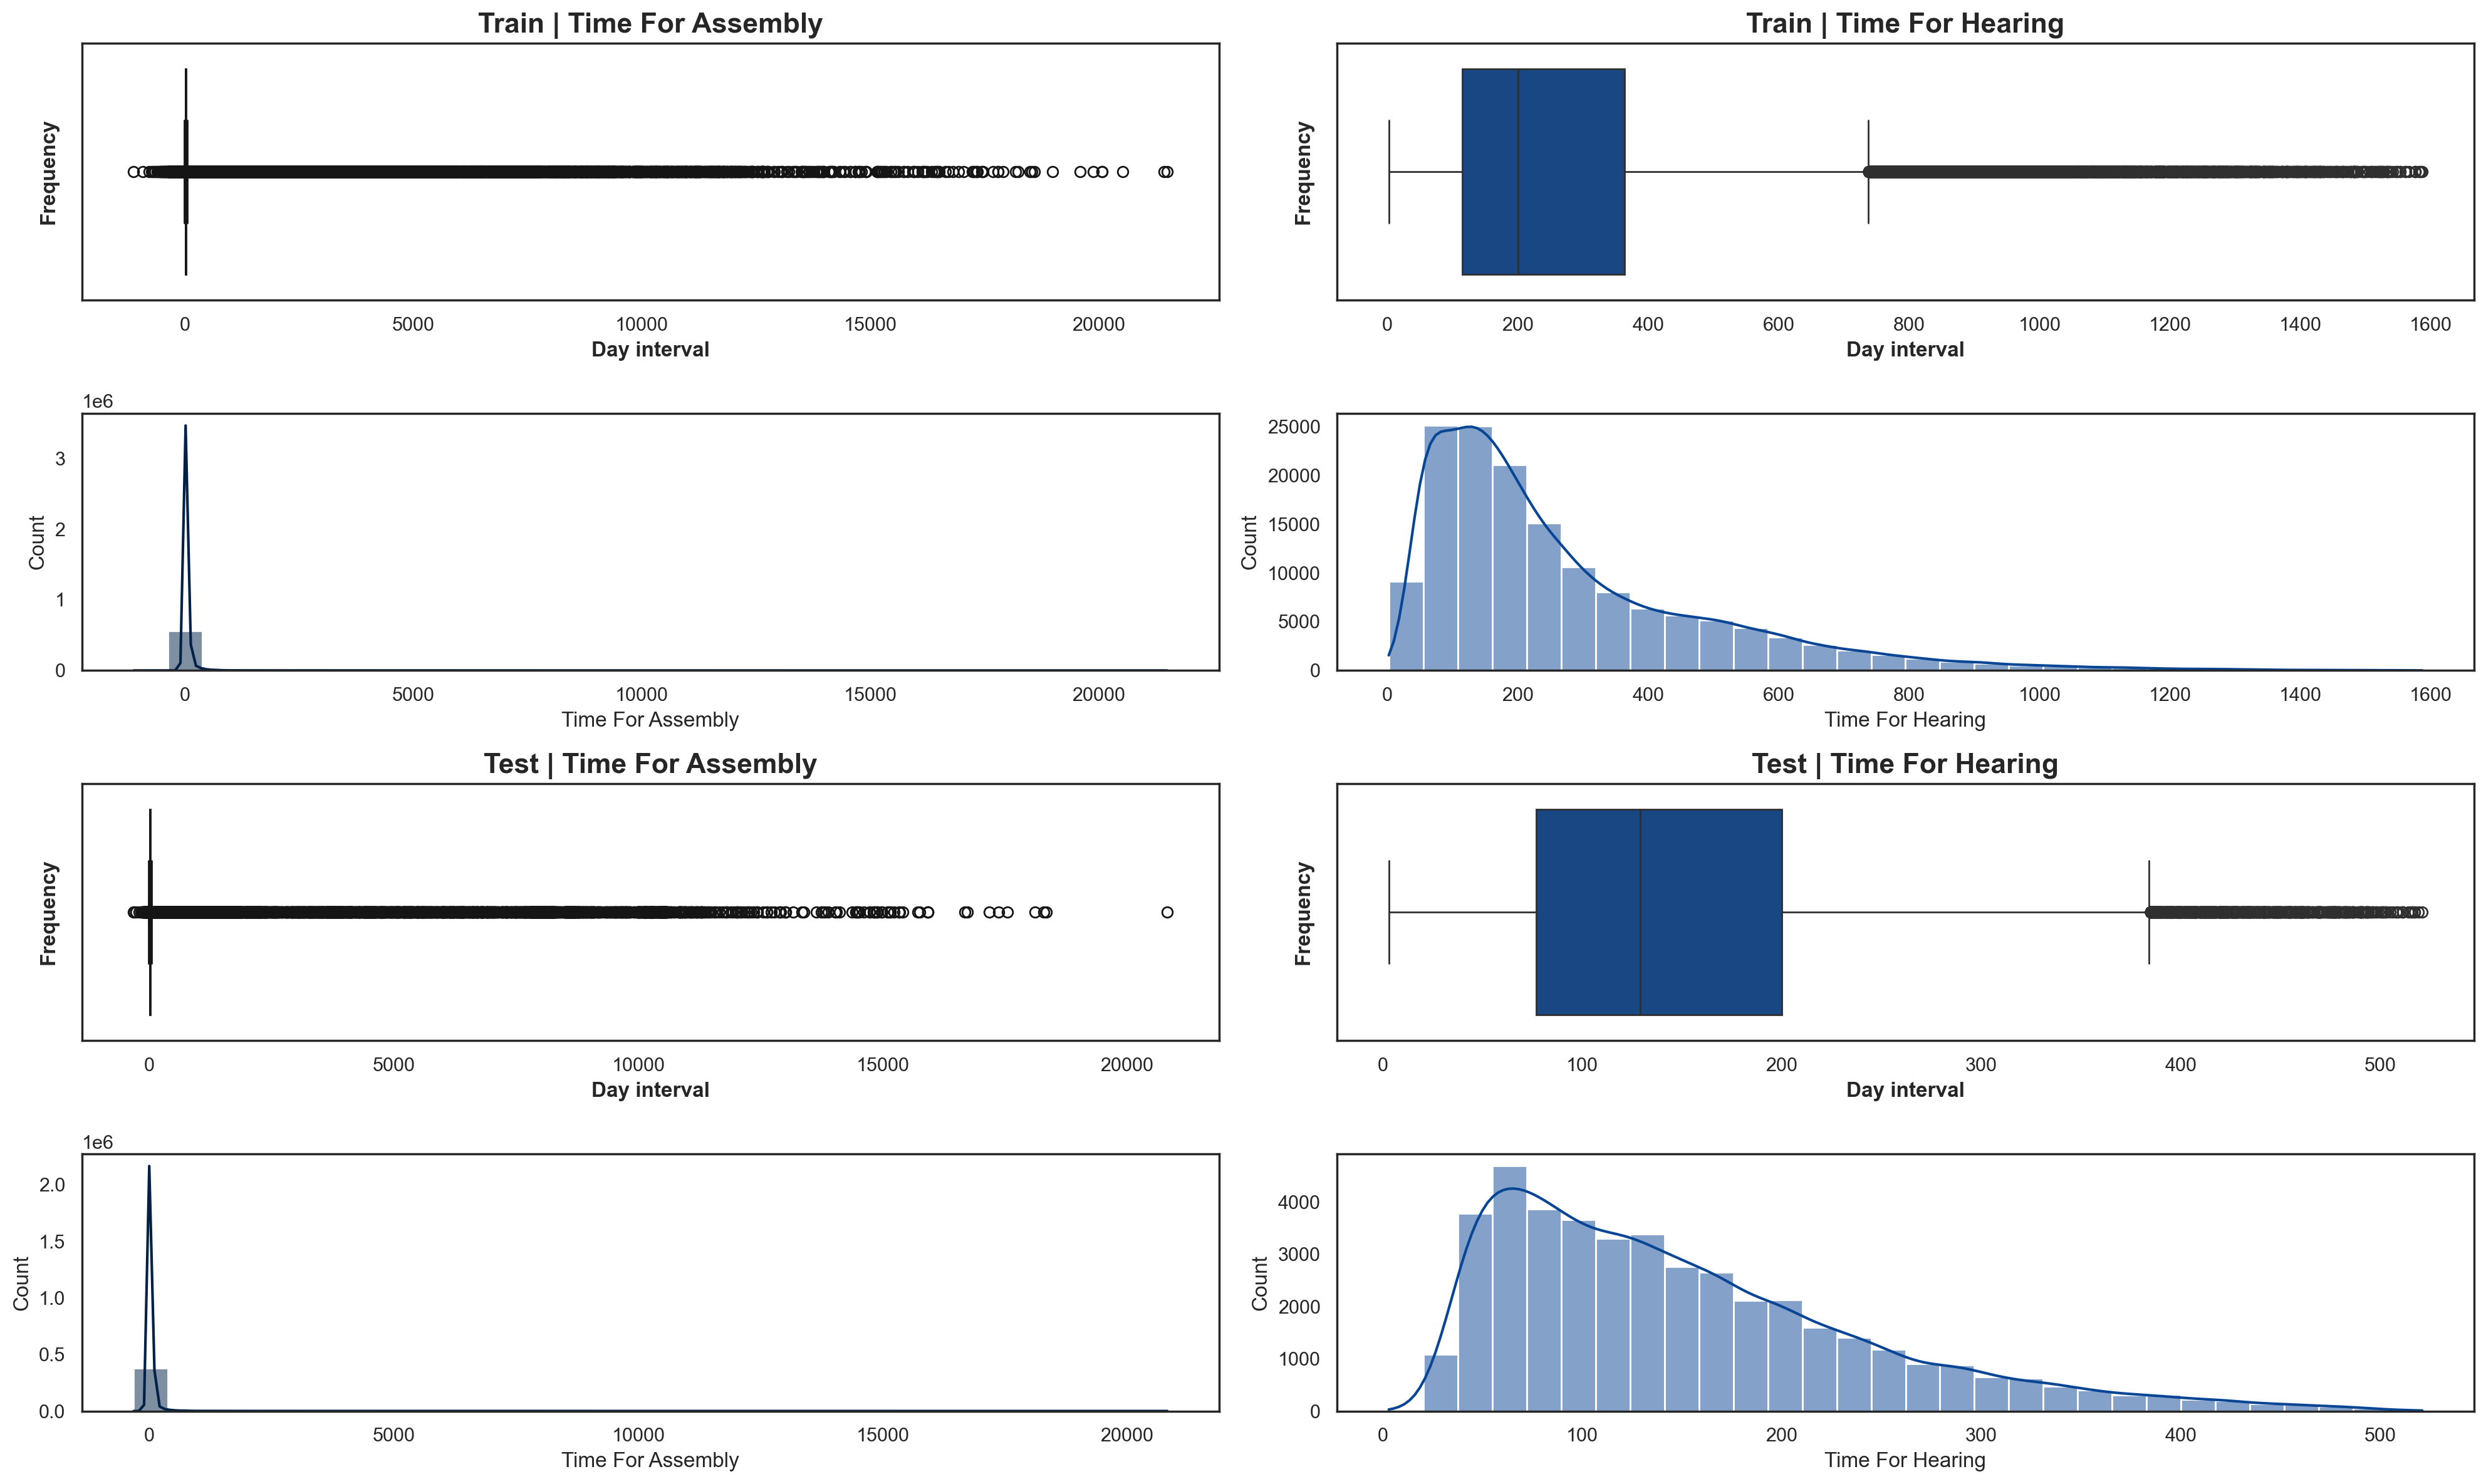

In [36]:
# BoxPlots for 'Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', and 'First Hearing Date' [Train Data & Test Data] (Outliers Detection)
# Columns to extract date features from
new_date_columns = ['Time For Assembly', 'Time For Hearing']

# Create the figure and subplots
fig, ax = plt.subplots(4, 2, figsize=(20, 12))

# BoxPlots
for i, col in enumerate(new_date_columns):

    sns.boxplot(x=train_data[col], color=palette[i % len(palette)], ax=ax[0, i])
    sns.histplot(train_data[col], kde=True, ax=ax[1, i], bins=30, color=palette[i % len(palette)])
    sns.boxplot(x=test_data[col], color=palette[i % len(palette)], ax=ax[2, i])
    sns.histplot(test_data[col], kde=True, ax=ax[3, i], bins=30, color=palette[i % len(palette)])
    ax[0, i].set_title(f'Train | {col}', fontsize=16, fontweight='bold')
    ax[2, i].set_title(f'Test | {col}', fontsize=16, fontweight='bold')
    ax[0, i].set_xlabel('Day interval', fontsize=12, fontweight='bold')
    ax[2, i].set_xlabel('Day interval', fontsize=12, fontweight='bold')
    ax[0, i].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax[2, i].set_ylabel('Frequency', fontsize=12, fontweight='bold')
 
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [37]:
print('Train | Negative times for assembly: ', train_time_for_assembly[train_time_for_assembly < 0].shape[0])
print('Test | Negative time for assembly: ', test_time_for_assembly[test_time_for_assembly < 0].shape[0])

Train | Negative times for assembly:  1407
Test | Negative time for assembly:  222


`NOTE` Negative differences are illogic, you cannot assemble the claim before the injury happened

In [39]:
train_illogical_index = train_time_for_assembly[train_time_for_assembly < 0].index
test_illogical_index = test_time_for_assembly[test_time_for_assembly < 0].index

train_data.loc[train_illogical_index, 'Claim Injury Type'].value_counts()

Claim Injury Type
5. PPD SCH LOSS    723
3. MED ONLY        350
4. TEMPORARY       255
2. NON-COMP         54
6. PPD NSL          14
1. CANCELLED         7
7. PTD               3
8. DEATH             1
Name: count, dtype: int64

There's no uniform classification for the inconsisten records, we cannot impute a prediction manually

In [41]:
# Outliers Detection for 'Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', and 'First Hearing Date' [Train Data]
for col in new_date_columns:
    detect_outliers(train_data[train_data['Time For Assembly'] >= 0], col, dfoutput=False, info=True)

print('----------------------------------------------------------------------------------------------------')

for col in new_date_columns:
    detect_outliers(test_data[test_data['Time For Assembly'] >= 0], col, dfoutput=False, info=True)

 Time For Assembly  
  1st Quartile: 5.0   | 3rd Quartile: 25.0   | IQR: 20.0 
  Lower Bound: -25.0   | Upper Bound: 55.0 

  Number of outliers: 72429 ( 12.73 %) 
    Min: 56.0   | Max: 21503.0 

 Time For Hearing  
  1st Quartile: 116.0   | 3rd Quartile: 366.0   | IQR: 250.0 
  Lower Bound: -259.0   | Upper Bound: 741.0 

  Number of outliers: 6847 ( 1.2 %) 
    Min: 742.0   | Max: 1587.0 

----------------------------------------------------------------------------------------------------
 Time For Assembly  
  1st Quartile: 4.0   | 3rd Quartile: 20.0   | IQR: 16.0 
  Lower Bound: -20.0   | Upper Bound: 44.0 

  Number of outliers: 45967 ( 11.93 %) 
    Min: 45.0   | Max: 20822.0 

 Time For Hearing  
  1st Quartile: 78.0   | 3rd Quartile: 201.0   | IQR: 123.0 
  Lower Bound: -106.5   | Upper Bound: 385.5 

  Number of outliers: 1058 ( 0.27 %) 
    Min: 386.0   | Max: 521.0 



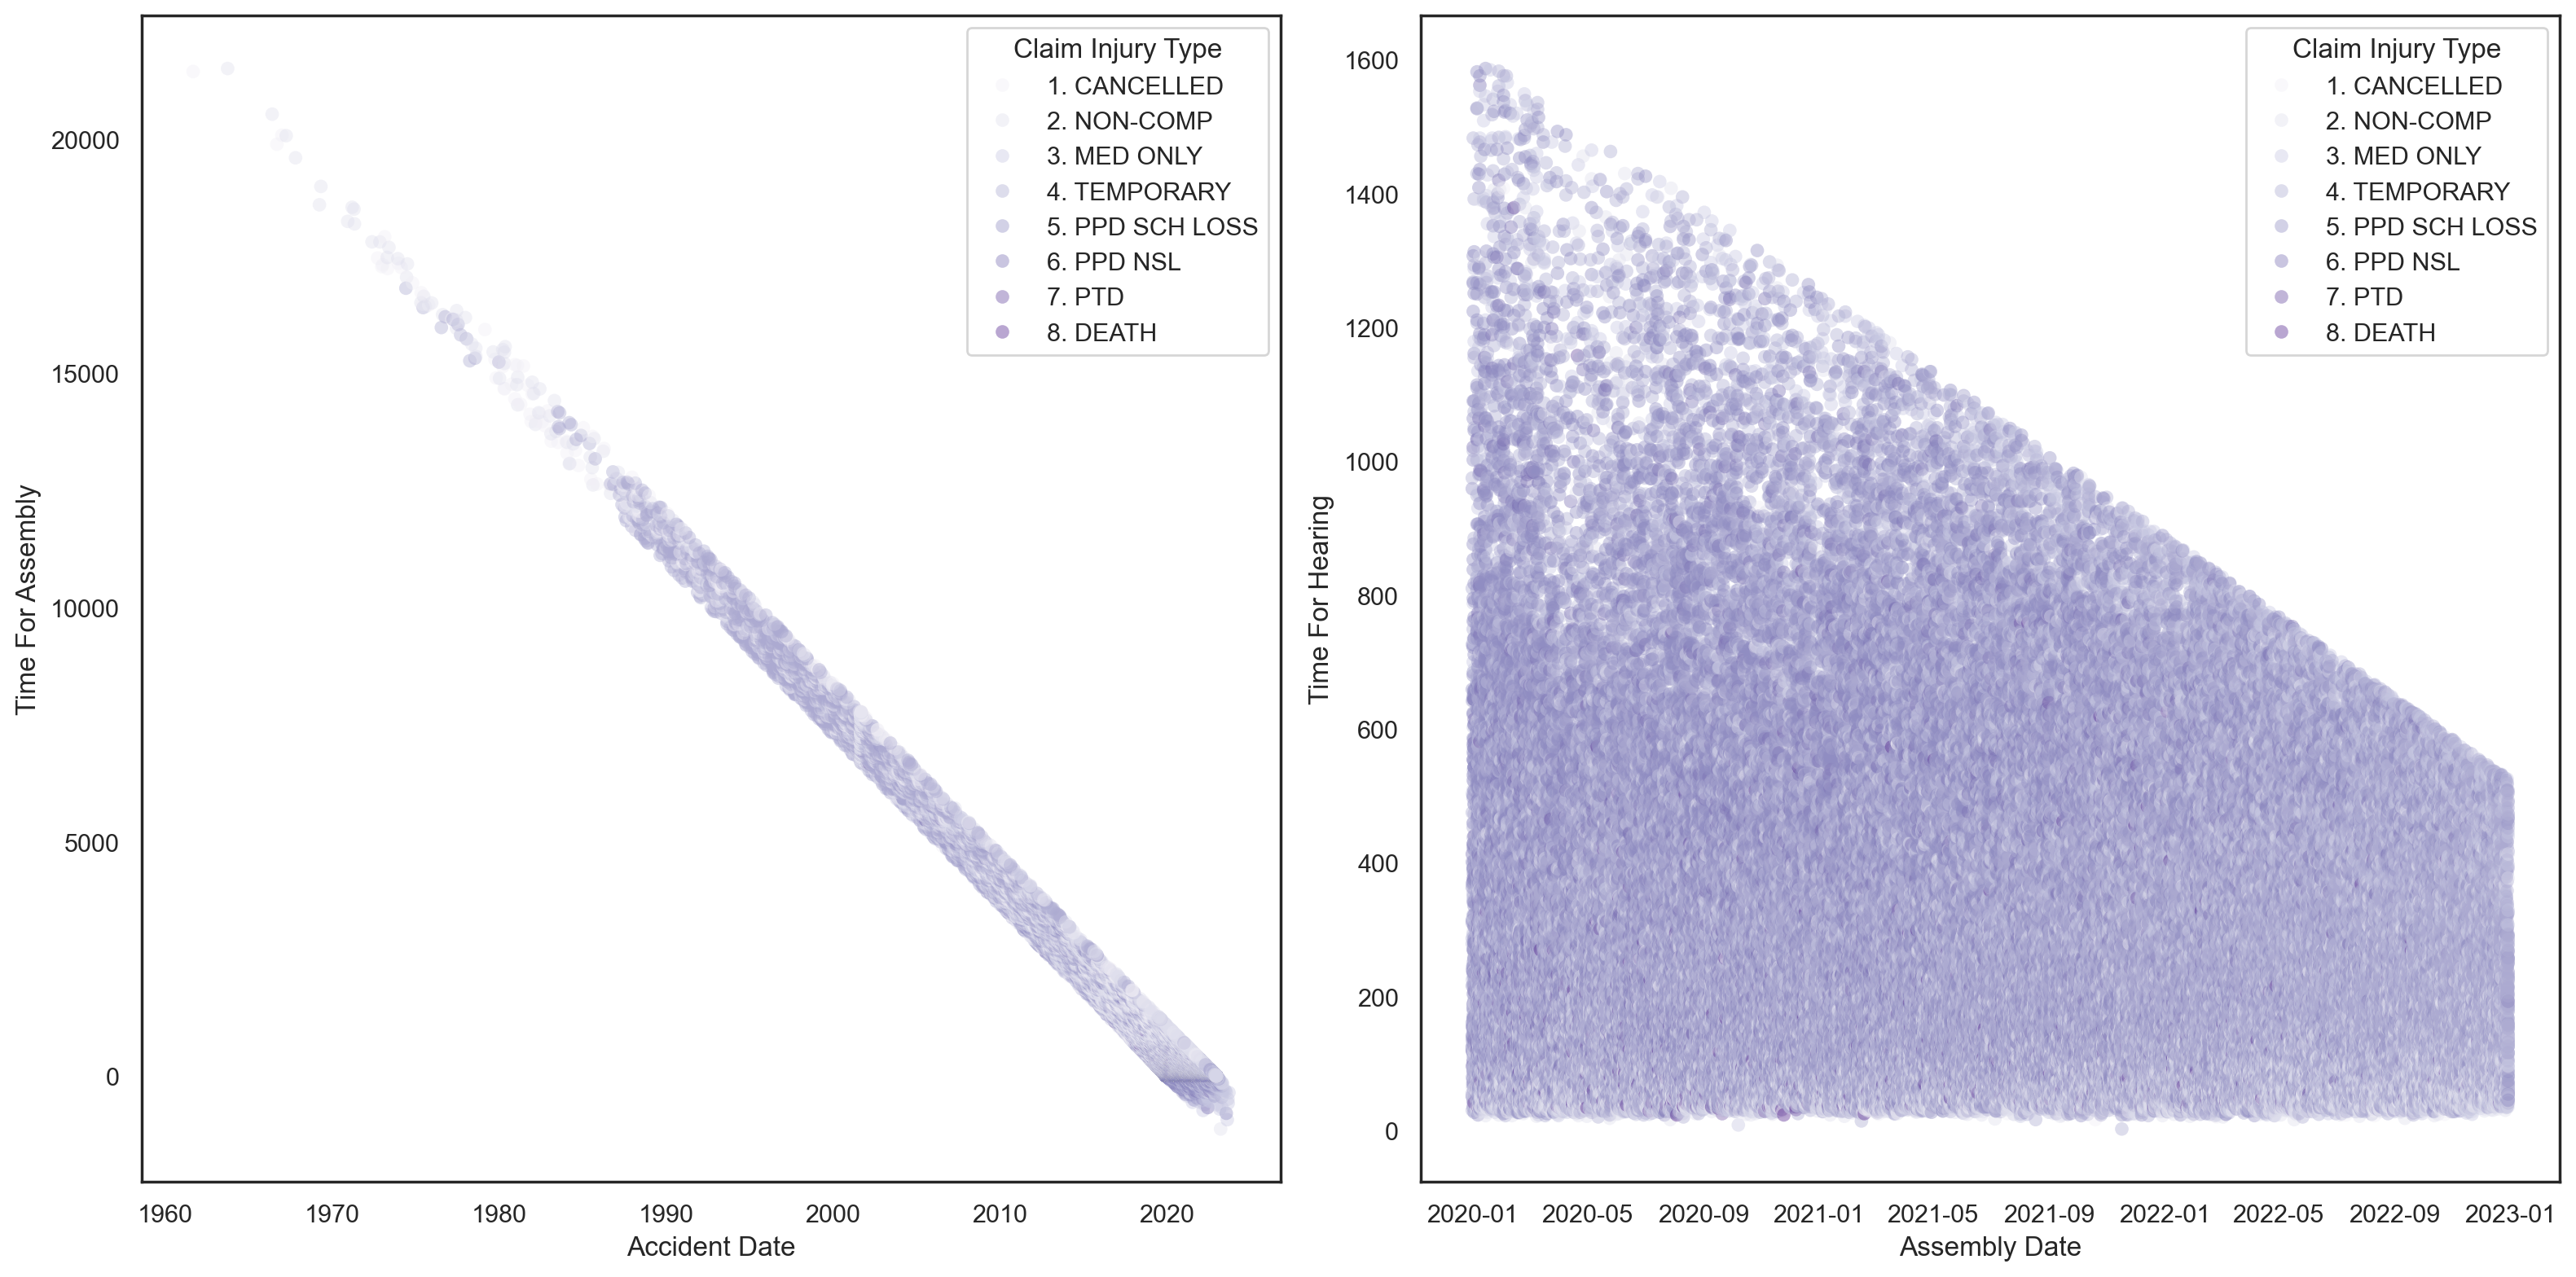

In [150]:
target_dict = {'1. CANCELLED': 10, 
               '2. NON-COMP': 20, 
               '3. MED ONLY': 30, 
               '4. TEMPORARY': 40, 
               '5. PPD SCH LOSS': 50, 
               '6. PPD NSL': 60, 
               '7. PTD': 70, 
               '8. DEATH': 80}
claim_code = train_data['Claim Injury Type'].map(target_dict)

fig, axes = plt.subplots(1,2, figsize=(16,8))

sns.scatterplot(data=train_data, x='Accident Date', y='Time For Assembly', ax=axes[0], 
                hue='Claim Injury Type', palette='Purples', edgecolor='none', alpha=0.4)
sns.scatterplot(data=train_data, x='Assembly Date', y='Time For Hearing', ax=axes[1], 
                hue='Claim Injury Type', palette='Purples', edgecolor='none', alpha=0.4)

plt.tight_layout()
plt.show()

Time For Assembly is definitely useless
<br>Time for Hearing seems not to separate Claim Injury Types

# Imputing NA function

In [43]:
def na_imputing(X_train, X_val, test_data):

    # make copies to impute and return
    X_train_imputed = X_train.copy()
    X_val_imputed = X_val.copy()
    test_data_imputed = test_data.copy()

    # Industry code
    X_train_imputed['Industry Code'] = X_train['Industry Code'].fillna(0)
    X_val_imputed['Industry Code'] = X_val['Industry Code'].fillna(0)
    test_data_imputed['Industry Code'] = test_data['Industry Code'].fillna(0)

    for col in ['Accident Date Year', 'Accident Date Month', 'Accident Date Day', 'Accident Date Weekday', 'Age at Injury Clean']:

        # Median value for each column in the training data only
        median_value = X_train[col].median()
    
        # Fill missing values in all sets with the training median
        X_train_imputed[col].fillna(median_value, inplace=True)
        X_val_imputed[col].fillna(median_value, inplace=True)
        test_data_imputed[col].fillna(median_value, inplace=True)

    
    X_train_knn_imputed_n = X_train_imputed.select_dtypes(include="number")    # Select numerical columns

    # Columns that are not numerical
    columns_to_drop_KNNImputer = ['Accident Date Binary', 'C-2 Date Binary', 'C-3 Date Binary', 'First Hearing Date Binary', 'IME-4 Reported', 'Weekly Wage Reported', 'Number of Dependents']
    X_train_knn_imputed_n = X_train_knn_imputed_n.drop(columns = columns_to_drop_KNNImputer)

    # Init the transformer
    knn_imp = KNNImputer()                                                         # k=5 is the default 

    # Fit/transform
    X_train_knn_imputed_n.loc[:, :] = knn_imp.fit_transform(X_train_knn_imputed_n)

    X_val_knn_imputed_n = X_val_imputed.select_dtypes(include="number")
    X_val_knn_imputed_n = X_val_knn_imputed_n.drop(columns = columns_to_drop_KNNImputer)
    X_val_knn_imputed_n.loc[:, :] = knn_imp.transform(X_val_knn_imputed_n)

    test_data_knn_imputed_n = test_data_imputed.select_dtypes(include="number")
    test_data_knn_imputed_n = test_data_knn_imputed_n.drop(columns = columns_to_drop_KNNImputer)
    test_data_knn_imputed_n.loc[:, :] = knn_imp.transform(test_data_knn_imputed_n)

    # Round the values of the 'C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year' that have been imputed
    X_train_knn_imputed_n[['C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year']] = \
    X_train_knn_imputed_n[['C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year']].round()
        
    X_val_knn_imputed_n[['C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year']] = \
    X_val_knn_imputed_n[['C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year']].round()
    
    test_data_knn_imputed_n[['C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year']] = \
    test_data_knn_imputed_n[['C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year']].round()

    # List of columns to be imputed
    columns_to_impute = ['C-2 Date Day', 'C-2 Date Month', 'C-2 Date Weekday', 'C-2 Date Year']

    # Replace only the specified columns with the imputed values
    X_train_imputed[columns_to_impute] = X_train_knn_imputed_n[columns_to_impute]
    X_val_imputed[columns_to_impute] = X_val_knn_imputed_n[columns_to_impute]
    test_data_imputed[columns_to_impute] = test_data_knn_imputed_n[columns_to_impute]

    for col in ['Accident Date Day', 'Accident Date Weekday', 'Accident Date Month', 'Accident Date Year',
            'C-2 Date Day', 'C-2 Date Month', 'C-2 Date Year', 'C-2 Date Weekday',
            'Age at Injury Clean', 'Industry Code']:
        X_train_imputed[col] = X_train_imputed[col].astype('int64')
        X_val_imputed[col] = X_val_imputed[col].astype('int64')
        test_data_imputed[col] = test_data_imputed[col].astype('int64')

    return X_train_imputed, X_val_imputed, test_data_imputed